# Transform and split DWPCs, assess performance

In [1]:
import itertools
import bz2

import pandas
import numpy
import sklearn.metrics

In [2]:
unperm_name = 'rephetio-v2.0'

In [3]:
feature_df = pandas.read_table('data/matrix/features.tsv.bz2')
feature_type_df = pandas.read_table('data/matrix/feature-type.tsv')

In [4]:
feature_df.head(2)

,hetnet,compound_id,disease_id,status,primary,disease_name,compound_name,prior_prob,CbG,CcSE,...,CuGuDpCpD,CuGuDpCtD,CuGuDpSpD,CuGuDrD,CuGuDrDrD,CuGuDtCpD,CuGuDtCtD,CuGuDuGaD,CuGuDuGdD,CuGuDuGuD
0,rephetio-v2.0_perm-5,DB00014,DOID:0060073,0,1,lymphatic system cancer,Goserelin,0.022675,2,249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,rephetio-v2.0,DB00091,DOID:0060073,0,1,lymphatic system cancer,Cyclosporine,0.047417,30,344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.028591,0.004754,0.0,0.0


In [5]:
feature_type_df.head(2)

,feature,feature_type,unperm_mean,unperm_sd
0,prior_prob,prior,0.040476,0.073232
1,CbG,degree,11.311000,12.444000


In [6]:
def transform_dwpcs(x, scaler):
    x = numpy.array(x)
    return numpy.arcsinh(x / scaler)

transformed_df = feature_df.copy()
dwpc_features = feature_type_df.query("feature_type == 'dwpc'").feature
feature_to_scaler = dict(zip(feature_type_df.feature, feature_type_df.unperm_mean))
for column in dwpc_features:
    transformed_df[column] = transform_dwpcs(transformed_df[column], feature_to_scaler[column])

In [7]:
dwpc_columns = list()
pdwpc_columns = list()
rdwpc_columns = list()
for column in dwpc_features:
    df = pandas.pivot_table(transformed_df, values=column, index=['compound_id', 'disease_id'], columns='hetnet')
    df = df[df['rephetio-v2.0'].notnull()]
    dwpc = df.iloc[:, 0]
    pdwpc = df.iloc[:, 1:].mean(axis='columns')
    rdwpc = dwpc - pdwpc
    dwpc_columns.append(dwpc)
    pdwpc_columns.append(pdwpc)
    rdwpc_columns.append(rdwpc)

dwpc_df = pandas.concat(dwpc_columns, axis=1)
pdwpc_df = pandas.concat(pdwpc_columns, axis=1)
rdwpc_df = pandas.concat(rdwpc_columns, axis=1)

for df in dwpc_df, pdwpc_df, rdwpc_df:
    df.columns = dwpc_features
    df.reset_index(inplace=True)

In [8]:
dwpc_df.head(3)

feature,compound_id,disease_id,CbG<rG<rGaD,CbG<rG<rGdD,CbG<rG<rGuD,CbG<rGaD,CbG<rGaDrD,CbG<rGbCpD,CbG<rGbCtD,CbG<rGcGaD,...,CuGuDpCpD,CuGuDpCtD,CuGuDpSpD,CuGuDrD,CuGuDrDrD,CuGuDtCpD,CuGuDtCtD,CuGuDuGaD,CuGuDuGdD,CuGuDuGuD
0,DB00014,DOID:10283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.227154,0.0,0.000000,2.453826,0.142122,0.615617,0.0,0.105593
1,DB00014,DOID:10534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.487357,0.0,0.680376,0.000000,0.000000,0.431882,0.0,0.000000
2,DB00014,DOID:12236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.207605,0.0,0.852775,0.000000,0.000000,0.164921,0.0,0.000000


In [9]:
pdwpc_df.head(3)

feature,compound_id,disease_id,CbG<rG<rGaD,CbG<rG<rGdD,CbG<rG<rGuD,CbG<rGaD,CbG<rGaDrD,CbG<rGbCpD,CbG<rGbCtD,CbG<rGcGaD,...,CuGuDpCpD,CuGuDpCtD,CuGuDpSpD,CuGuDrD,CuGuDrDrD,CuGuDtCpD,CuGuDtCtD,CuGuDuGaD,CuGuDuGdD,CuGuDuGuD
0,DB00014,DOID:10283,0.043621,0.028787,0.022707,0.0,0.000000,0.0,0.326014,0.228354,...,0.597241,0.796495,0.165213,0.0,0.000000,0.0,0.000000,0.508843,0.388299,0.209833
1,DB00014,DOID:10534,0.058666,0.000000,0.000000,0.0,0.052024,0.0,0.000000,0.033004,...,0.000000,0.000000,0.174077,0.0,0.317700,0.0,0.000000,0.342985,0.000000,0.000000
2,DB00014,DOID:12236,0.025909,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.163024,0.0,0.326497,0.0,0.253883,0.258618,0.000000,0.000000


In [10]:
rdwpc_df.head(3)

feature,compound_id,disease_id,CbG<rG<rGaD,CbG<rG<rGdD,CbG<rG<rGuD,CbG<rGaD,CbG<rGaDrD,CbG<rGbCpD,CbG<rGbCtD,CbG<rGcGaD,...,CuGuDpCpD,CuGuDpCtD,CuGuDpSpD,CuGuDrD,CuGuDrDrD,CuGuDtCpD,CuGuDtCtD,CuGuDuGaD,CuGuDuGdD,CuGuDuGuD
0,DB00014,DOID:10283,-0.043621,-0.028787,-0.022707,0.0,0.000000,0.0,-0.326014,-0.228354,...,-0.597241,-0.796495,0.061940,0.0,0.000000,2.453826,0.142122,0.106774,-0.388299,-0.10424
1,DB00014,DOID:10534,-0.058666,0.000000,0.000000,0.0,-0.052024,0.0,0.000000,-0.033004,...,0.000000,0.000000,0.313280,0.0,0.362676,0.000000,0.000000,0.088897,0.000000,0.00000
2,DB00014,DOID:12236,-0.025909,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.044581,0.0,0.526278,0.000000,-0.253883,-0.093697,0.000000,0.00000


In [11]:
part_df = pandas.read_table('data/partitions.tsv')
part_df = part_df.query("hetnet == @unperm_name")
part_df = part_df[['compound_id', 'disease_id', 'status']]

dwpc_df = part_df.merge(dwpc_df)
pdwpc_df = part_df.merge(pdwpc_df)
rdwpc_df = part_df.merge(rdwpc_df)

In [21]:
for df, name in (dwpc_df, 't-dwpc'), (pdwpc_df, 'pt-dwpc'), (rdwpc_df, 'rt-dwpc'):
    path = 'data/matrix/rephetio-v2.0/{}.tsv.bz2'.format(name)
    with bz2.open(path, 'wt') as write_file:
        df.to_csv(write_file, sep='\t', index=False, float_format='%.5g')

### Compute performance

In [13]:
primary_auroc_df = pandas.read_table('data/feature-performance/primary-aurocs.tsv')
primary_auroc_df = primary_auroc_df.rename(columns={'auroc': 'dwpc_auroc', 'auroc_permuted': 'pdwpc_primary_auroc', 'pval_auroc': 'pval_delta_auroc'})
primary_auroc_df = primary_auroc_df[['feature', 'nonzero', 'dwpc_auroc', 'pdwpc_primary_auroc', 'delta_auroc', 'pval_delta_auroc']]

In [14]:
rows  = list()
for feature in dwpc_features:
    rows.append([
        feature,
        sklearn.metrics.roc_auc_score(pdwpc_df.status, pdwpc_df[feature]),
        sklearn.metrics.roc_auc_score(rdwpc_df.status, rdwpc_df[feature]),
    ])
auroc_df = pandas.DataFrame(rows, columns=['feature', 'pdwpc_auroc', 'rdwpc_auroc'])
auroc_df = auroc_df.merge(primary_auroc_df)

auroc_df.head(2)

,feature,pdwpc_auroc,rdwpc_auroc,nonzero,dwpc_auroc,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
0,CbG<rG<rGaD,0.613955,0.574447,0.84662,0.63605,0.56577,0.070275,0.000020
1,CbG<rG<rGdD,0.570848,0.536699,0.38146,0.58014,0.54954,0.030600,0.000103


In [15]:
auroc_df.to_csv('data/feature-performance/auroc.tsv', sep='\t', index=False, float_format='%.5g')

In [16]:
#auroc_df.sort_values('rdwpc_auroc', ascending = False)
auroc_df[-auroc_df.feature.str.contains('CtD')].sort_values('rdwpc_auroc', ascending = False).head()

,feature,pdwpc_auroc,rdwpc_auroc,nonzero,dwpc_auroc,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
27,CbGaD,0.628067,0.669358,0.32238,0.71284,0.56754,0.145300,6.114000e-07
178,CbGpPWpGaD,0.650548,0.654061,0.97642,0.70155,0.62547,0.076082,1.372500e-08
679,CrCbGaD,0.589791,0.642535,0.41748,0.64808,0.56589,0.082185,8.079100e-07
519,CiPCiCbGaD,0.606607,0.639864,0.35576,0.65760,0.56734,0.090258,1.038500e-05
752,CrCrCbGaD,0.593827,0.639633,0.51709,0.62044,0.58001,0.040433,4.739400e-05


## Visualization Sandbox

In [17]:
%matplotlib inline
import seaborn

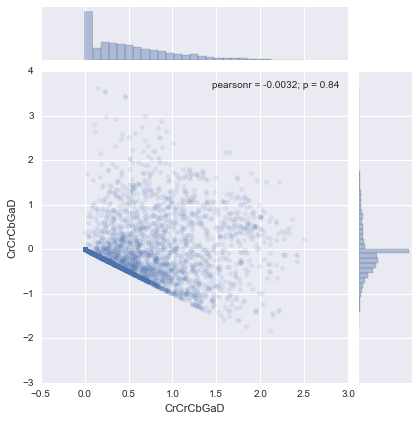

In [18]:
seaborn.jointplot(pdwpc_df['CrCrCbGaD'], rdwpc_df['CrCrCbGaD'], alpha = 0.1);

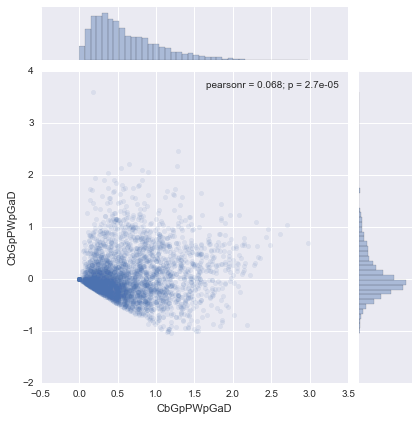

In [19]:
seaborn.jointplot(pdwpc_df['CbGpPWpGaD'], rdwpc_df['CbGpPWpGaD'], alpha = 0.1);